In [1]:
# =========================================================
# 01) Chargement & préparation des mappings de classes
#     (depuis p9dg/utils/class_mappings.py)
# =========================================================
import os, sys
from pathlib import Path

# 👉 Racine projet (modifiable via env var)
PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "/workspace")).resolve()

# 👉 S'assurer que p9dg/utils est importable
UTILS_PATH = PROJECT_ROOT / "p9dg" / "utils"
if str(UTILS_PATH) not in sys.path:
    sys.path.append(str(UTILS_PATH))

from class_mappings import class_labels, class_colors, make_idx_mappings

# --- Paramètre : inclure l'arrière-plan ? ---
INCLUDE_BACK = True  # passe à True si tu veux garder BACK

# --- Codes de classes (dans l'ordre alphabétique, option BACK) ---
ALL_CODES = sorted(class_labels.keys())
CLASS_CODES = [c for c in ALL_CODES if INCLUDE_BACK or c != "BACK"]

# --- Dictionnaires de base (code -> nom / couleur) ---
NAME_BY_CODE  = class_labels            # e.g. "TUM" -> "Épithélium adénocarcinomateux (tumeur)"
COLOR_BY_CODE = class_colors            # e.g. "TUM" -> "#000000"

# --- Listes prêtes à l'emploi pour plots ---
CLASS_NAMES   = [NAME_BY_CODE[c]  for c in CLASS_CODES]   # noms FR dans le même ordre que CLASS_CODES
CLASS_COLORS  = [COLOR_BY_CODE[c] for c in CLASS_CODES]   # couleurs alignées

# --- Helpers utiles ---
def code_to_label(code: str) -> str:
    return NAME_BY_CODE.get(code, code)

def code_to_color(code: str) -> str:
    return COLOR_BY_CODE.get(code, "#333333")

def codes_to_labels(codes):
    return [code_to_label(c) for c in codes]

def codes_to_colors(codes):
    return [code_to_color(c) for c in codes]

# --- Mappings indexés (si tu as un Dataset avec class_to_idx) ---
# Exemple d’usage:
#   idx_to_name, idx_to_color, name_to_color = make_idx_mappings(class_to_idx)
#   # où class_to_idx ressemble à {"ADI":0, "LYM":1, ...}
#
# Ici, on expose juste la fonction importée ; tu l’appelleras
# au moment où ton DataLoader fournit class_to_idx.
make_idx_mappings  # (exposé pour rappel)

# --- Debug court ---
print("PROJECT_ROOT       :", PROJECT_ROOT)
print("INCLUDE_BACK       :", INCLUDE_BACK)
print("CLASS_CODES        :", CLASS_CODES)
print("Nb classes (eff.)  :", len(CLASS_CODES))


PROJECT_ROOT       : /workspace
INCLUDE_BACK       : True
CLASS_CODES        : ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']
Nb classes (eff.)  : 9


In [2]:
# =========================================================
# 02) Chargement du CSV PixCell (réel ↔ synthétique)
# =========================================================
import pandas as pd

CSV_PATH = PROJECT_ROOT / "outputs" / "pixcell_out_histo" / "pixcell_metadata_1762290553.csv"
assert CSV_PATH.exists(), f"Fichier introuvable : {CSV_PATH}"

df_pixcell = pd.read_csv(CSV_PATH)
print(f"✅ CSV chargé : {len(df_pixcell)} paires d'images")
display(df_pixcell.head())


✅ CSV chargé : 2700 paires d'images


,global_index,ref_path,ref_label,ref_label_full,ref_color,seed,out_path,guidance_scale,steps
0,0,/workspace/data/NCT-CRC-HE-100K/MUS/MUS-SDYMES...,MUS,Tissu musculaire lisse,#D73027,2025,/workspace/outputs/pixcell_out_histo/MUS/MUS-S...,2.0,28
1,1,/workspace/data/NCT-CRC-HE-100K/LYM/LYM-RAAIND...,LYM,Lymphocytes (infiltrat immunitaire),#4575B4,2026,/workspace/outputs/pixcell_out_histo/LYM/LYM-R...,2.0,28
2,2,/workspace/data/NCT-CRC-HE-100K/MUS/MUS-PKGEPS...,MUS,Tissu musculaire lisse,#D73027,2027,/workspace/outputs/pixcell_out_histo/MUS/MUS-P...,2.0,28
3,3,/workspace/data/NCT-CRC-HE-100K/MUC/MUC-LSWDFW...,MUC,Mucus (sécrétions),#74ADD1,2028,/workspace/outputs/pixcell_out_histo/MUC/MUC-L...,2.0,28
4,4,/workspace/data/NCT-CRC-HE-100K/ADI/ADI-GNDQQY...,ADI,Tissu adipeux,#F2CEEE,2029,/workspace/outputs/pixcell_out_histo/ADI/ADI-G...,2.0,28


In [3]:
# =========================================================
# 03) Chargement du PathoDuET extractor (gelé, DeiT-B/16 224)
# =========================================================
import re, torch
import torch.nn as nn
import torch.nn.functional as F

try:
    import timm
except Exception as e:
    raise RuntimeError("❌ timm non installé — installe-le avec `pip install timm`")

CKPT_PATH = PROJECT_ROOT / "models" / "checkpoint_HE.pth"
assert CKPT_PATH.exists(), f"Checkpoint introuvable: {CKPT_PATH}"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🧠 Chargement PathoDuET sur {DEVICE}")

# --- Fonction utilitaire pour nettoyer le state_dict ---
def load_state_dict_safely(path):
    """Charge un state_dict timm depuis un checkpoint PathoDuET."""
    sd_raw = None
    try:
        obj = torch.load(path, map_location="cpu", weights_only=True)
        if isinstance(obj, dict) and all(hasattr(v, "shape") for v in obj.values()):
            sd_raw = obj
        elif isinstance(obj, dict):
            for k in ("state_dict", "model", "module"):
                if k in obj and isinstance(obj[k], dict) and all(hasattr(v, "shape") for v in obj[k].values()):
                    sd_raw = obj[k]; break
    except TypeError:
        obj = torch.load(path, map_location="cpu")
        if isinstance(obj, dict) and all(hasattr(v, "shape") for v in obj.values()):
            sd_raw = obj
        elif isinstance(obj, dict):
            for k in ("state_dict", "model", "module"):
                if k in obj and isinstance(obj[k], dict) and all(hasattr(v, "shape") for v in obj[k].values()):
                    sd_raw = obj[k]; break
    if sd_raw is None:
        raise RuntimeError("❌ state_dict non trouvé dans le checkpoint")
    
    # Nettoyage
    clean_sd = {re.sub(r"^(module\.|model\.)", "", k): v for k, v in sd_raw.items()}
    clean_sd.pop("dist_token", None)
    for k in list(clean_sd.keys()):
        if k.startswith("head_dist."):
            clean_sd.pop(k)
    # Corriger pos_embed 198→197 si nécessaire
    if "pos_embed" in clean_sd and clean_sd["pos_embed"].shape[1] == 198:
        pos = clean_sd["pos_embed"]
        clean_sd["pos_embed"] = torch.cat([pos[:, :1, :], pos[:, 2:, :]], dim=1)
    # Supprimer la tête de classification
    for k in list(clean_sd.keys()):
        if k.startswith("head."):
            clean_sd.pop(k)
    return clean_sd

# --- Chargement du backbone DeiT-B/16 224 ---
state_dict = load_state_dict_safely(CKPT_PATH)
backbone = timm.create_model(
    "deit_base_patch16_224",
    pretrained=False,
    num_classes=0,
    img_size=224,
    global_pool="avg"
)
missing, unexpected = backbone.load_state_dict(state_dict, strict=False)
print(f"🔧 Weights chargés — missing: {len(missing)}, unexpected: {len(unexpected)}")
for p in backbone.parameters():
    p.requires_grad_(False)
backbone.eval()

# --- Définition de la classe wrapper PathoDuET ---
class PathoDuetExtractor(nn.Module):
    """Extracteur de features PathoDuET (DeiT-B/16 gelé)."""
    def __init__(self, bb, in_size=224):
        super().__init__()
        self.bb = bb
        self.in_size = in_size
    @torch.no_grad()
    def forward(self, x_m11):
        # Normalisation -1→1 → 0→1
        x01 = (x_m11.clamp(-1, 1) + 1) * 0.5
        # Redimensionner si nécessaire
        if x01.shape[-2:] != (self.in_size, self.in_size):
            x01 = F.interpolate(x01, size=(self.in_size, self.in_size),
                                mode="bilinear", align_corners=False)
        return self.bb(x01)

# --- Instanciation ---
pathoduet = PathoDuetExtractor(backbone).to(DEVICE).eval()

# --- Test rapide ---
xb = torch.randn(2, 3, 256, 256)  # batch factice
with torch.no_grad():
    f = pathoduet(xb.to(DEVICE))
print("✅ PathoDuET extractor prêt — features:", tuple(f.shape))


🧠 Chargement PathoDuET sur cuda
🔧 Weights chargés — missing: 0, unexpected: 1
✅ PathoDuET extractor prêt — features: (2, 768)


In [4]:
# =========================================================
# 04) Dataset & extraction des embeddings (PathoDuET)
# =========================================================
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from tqdm import tqdm
import torch

# 🔧 Transfos : RGB → tensor [0,1] → mise à l’échelle [-1,1]
to_m11 = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32) if hasattr(transforms, "ConvertImageDtype") else transforms.Lambda(lambda x: x.float()),
    transforms.Lambda(lambda x: x * 2.0 - 1.0),
])
img_tf = transforms.Compose([
    transforms.ToTensor(),   # [0,1]
    to_m11,                  # [-1,1]
])

class PathoPairsDataset(Dataset):
    """
    Dataset minimal pour extraire des embeddings d'images.
    - df             : DataFrame contenant une colonne image et une colonne label
    - img_col        : 'ref_path' ou 'out_path'
    - label_col      : 'ref_label'
    - drop_missing   : supprime les entrées dont les chemins n'existent pas
    - allow_codes    : option pour ne garder qu'un sous-ensemble de classes (codes)
    """
    def __init__(self, df, img_col: str, label_col: str,
                 transform=None, drop_missing=True, allow_codes=None):
        df_ = df.copy()
        if allow_codes is not None:
            df_ = df_[df_[label_col].isin(allow_codes)]
        if drop_missing:
            df_ = df_[df_[img_col].apply(lambda p: Path(str(p)).exists())]
        self.paths = df_[img_col].astype(str).values
        self.labels = df_[label_col].astype(str).values
        self.transform = transform or img_tf

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        img = Image.open(p).convert("RGB")
        x = self.transform(img)
        y = self.labels[idx]
        return x, y

def extract_embeddings(model, df, img_col: str, label_col: str,
                       batch_size: int = 32, num_workers: int = 2,
                       allow_codes=None, desc="Extraction"):
    """
    Retourne:
      - feats: np.ndarray (N, D)
      - labels: np.ndarray (N,)
    """
    ds = PathoPairsDataset(df, img_col, label_col, transform=img_tf,
                           drop_missing=True, allow_codes=allow_codes)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False,
                    num_workers=0, pin_memory=torch.cuda.is_available())
    feats, labels = [], []

    model.eval()
    with torch.no_grad():
        for xb, yb in tqdm(dl, desc=desc, leave=False):
            xb = xb.to(DEVICE, non_blocking=True)
            fb = model(xb)                  # PathoDuET -> (B, D)
            if fb.ndim > 2:                 # garde-fou
                fb = torch.flatten(fb, 1)
            feats.append(fb.cpu().numpy())
            labels.extend(list(yb))

    feats = np.concatenate(feats, axis=0) if feats else np.zeros((0, 768), dtype=np.float32)
    labels = np.array(labels)
    return feats, labels

print("✅ Dataset & extraction prêts (entrées en [-1,1], resize géré dans PathoDuET).")


✅ Dataset & extraction prêts (entrées en [-1,1], resize géré dans PathoDuET).


In [5]:
# =========================================================
# 05) Extraction des features réelles et synthétiques
# =========================================================
# Option : limiter aux classes utiles (exclut BACK si INCLUDE_BACK=False)
ALLOW_CODES = CLASS_CODES  # ou None pour tout prendre

features_real, labels_real = extract_embeddings(
    model=pathoduet,
    df=df_pixcell,
    img_col="ref_path",
    label_col="ref_label",
    batch_size=32,
    num_workers=2,
    allow_codes=ALLOW_CODES,
    desc="Embeddings RÉELS"
)

features_fake, labels_fake = extract_embeddings(
    model=pathoduet,
    df=df_pixcell,
    img_col="out_path",
    label_col="ref_label",
    batch_size=32,
    num_workers=2,
    allow_codes=ALLOW_CODES,
    desc="Embeddings SYNTHÉTIQUES"
)

print("✅ Extraction terminée")
print(" - Embeddings réels        :", features_real.shape)
print(" - Embeddings synthétiques :", features_fake.shape)

# Sécurité : on vérifie l'alignement des ensembles de classes
print("Classes rencontrées (réels)       :", sorted(set(labels_real)))
print("Classes rencontrées (synthétiques):", sorted(set(labels_fake)))


✅ Extraction terminée
 - Embeddings réels        : (2700, 768)
 - Embeddings synthétiques : (2700, 768)
Classes rencontrées (réels)       : ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']
Classes rencontrées (synthétiques): ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']


In [6]:
# # =========================================================
# # 06) Réduction de dimension (t-SNE ou UMAP)
# # =========================================================
# from sklearn.manifold import TSNE
# import numpy as np

# # Concatène les embeddings et crée les étiquettes de domaine
# X = np.concatenate([features_real, features_fake])
# y = np.concatenate([labels_real, labels_fake])
# domain = np.array(["Réel"] * len(features_real) + ["Synthétique"] * len(features_fake))

# print("🚀 Lancement t-SNE (2D)...")
# tsne = TSNE(n_components=2, perplexity=30, random_state=42, learning_rate="auto", init="pca")
# X_2d = tsne.fit_transform(X)

# print("✅ Réduction terminée :", X_2d.shape)
# =========================================================
# 06-bis) Réduction de dimension 3D (t-SNE ou UMAP)
# =========================================================
from sklearn.manifold import TSNE
import numpy as np

X = np.concatenate([features_real, features_fake])
y = np.concatenate([labels_real, labels_fake])
domain = np.array(["Réel"] * len(features_real) + ["Synthétique"] * len(features_fake))

print("🚀 Lancement t-SNE (3D)...")
tsne = TSNE(
    n_components=3,
    perplexity=30,
    random_state=42,
    learning_rate="auto",
    init="pca"
)
X_3d = tsne.fit_transform(X)
print("✅ Réduction terminée :", X_3d.shape)


🚀 Lancement t-SNE (3D)...
✅ Réduction terminée : (5400, 3)


In [7]:
# =========================================================
# 07-ter) Visualisation 3D avec liseré contrasté sur Synthétique
# =========================================================
import plotly.graph_objects as go
import numpy as np
import pandas as pd

df_vis = pd.DataFrame({
    "x": X_3d[:, 0],
    "y": X_3d[:, 1],
    "z": X_3d[:, 2],
    "Classe": np.array(y),
    "Type":   np.array(domain),
})

classes = sorted(df_vis["Classe"].unique())

def hex_to_rgb(hex_color: str):
    hex_color = hex_color.lstrip("#")
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

def relative_luminance(hex_color: str) -> float:
    r, g, b = [c/255.0 for c in hex_to_rgb(hex_color)]
    def _gamma(u): 
        return ((u+0.055)/1.055)**2.4 if u > 0.04045 else u/12.92
    R, G, B = _gamma(r), _gamma(g), _gamma(b)
    return 0.2126*R + 0.7152*G + 0.0722*B

def outline_for_fill(fill_hex: str, cls_code: str):
    # Contraste spécial demandé pour TUM
    if cls_code == "TUM":
        return "#FFD700"  # jaune
    # Sinon, contraste simple : noir si couleur claire, blanc si foncée
    return "#000000" if relative_luminance(fill_hex) > 0.6 else "#FFFFFF"

fig = go.Figure()

for cls in classes:
    c_hex = class_colors.get(cls, "#666666")
    # --- Réel (cercles, pas de liseré fort)
    dfr = df_vis[(df_vis["Classe"] == cls) & (df_vis["Type"] == "Réel")]
    if len(dfr):
        fig.add_trace(go.Scatter3d(
            x=dfr["x"], y=dfr["y"], z=dfr["z"],
            mode="markers",
            name=f"{cls} — Réel",
            legendgroup=cls,
            marker=dict(
                symbol="circle",
                size=5,
                color=c_hex,
                opacity=0.8,
                line=dict(width=0.5, color="rgba(0,0,0,0.25)")
            )
        ))

    # --- Synthétique (losanges, liseré contrasté)
    dfs = df_vis[(df_vis["Classe"] == cls) & (df_vis["Type"] == "Synthétique")]
    if len(dfs):
        outline = outline_for_fill(c_hex, cls)
        fig.add_trace(go.Scatter3d(
            x=dfs["x"], y=dfs["y"], z=dfs["z"],
            mode="markers",
            name=f"{cls} — Synthétique",
            legendgroup=cls,
            marker=dict(
                symbol="diamond",
                size=6,
                color=c_hex,
                opacity=0.85,
                line=dict(width=1, color=outline)  # ⭐ liseré contrasté ici
            )
        ))

fig.update_layout(
    title="Espace des embeddings PathoDuET — Réel vs Synthétique (3D, liseré sur Synthétique)",
    width=1000, height=820,
    legend_title_text="Classe / Domaine",
    scene=dict(
        xaxis=dict(showbackground=False, showticklabels=False, title=""),
        yaxis=dict(showbackground=False, showticklabels=False, title=""),
        zaxis=dict(showbackground=False, showticklabels=False, title="")
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()


In [8]:
# =========================================================
# 08-bis) Distance des centroïdes normalisée par la variance intra-classe réelle
# =========================================================
import numpy as np
import pandas as pd

# Récupération des embeddings et labels
features_all = np.concatenate([features_real, features_fake])
labels_all   = np.concatenate([labels_real, labels_fake])
domains_all  = np.array(["Réel"] * len(features_real) + ["Synthétique"] * len(features_fake))

df_embed = pd.DataFrame({
    "label": labels_all,
    "domain": domains_all
})
df_embed["feat"] = list(features_all)

# --- Calcul centroïdes et écarts types intra-classe réels ---
centroids_real, centroids_fake, std_real = {}, {}, {}

for cls in sorted(set(labels_all)):
    Xr = np.stack(df_embed.loc[(df_embed["label"]==cls) & (df_embed["domain"]=="Réel"), "feat"])
    Xf = np.stack(df_embed.loc[(df_embed["label"]==cls) & (df_embed["domain"]=="Synthétique"), "feat"])

    centroids_real[cls] = Xr.mean(0)
    centroids_fake[cls] = Xf.mean(0)

    # Dispersion moyenne intra-classe réelle (écart-type global)
    std_real[cls] = float(np.mean(np.std(Xr, axis=0)))

# --- Distances normalisées ---
centroid_dists = {}
centroid_dists_norm = {}

for cls in centroids_real.keys():
    dist = np.linalg.norm(centroids_real[cls] - centroids_fake[cls])
    centroid_dists[cls] = float(dist)
    centroid_dists_norm[cls] = float(dist / (std_real[cls] + 1e-8))  # évite /0

# --- Tableau récapitulatif ---
df_dists = pd.DataFrame({
    "Classe": list(centroid_dists.keys()),
    "Distance_brute": list(centroid_dists.values()),
    "Distance_normalisée": list(centroid_dists_norm.values())
}).sort_values("Distance_normalisée")

display(df_dists.style.background_gradient(subset=["Distance_normalisée"], cmap="YlOrRd"))

# Moyennes globales
mean_raw  = df_dists["Distance_brute"].mean()
mean_norm = df_dists["Distance_normalisée"].mean()

print(f"\n📏 Moyenne globale des distances :")
print(f"   • Brute        = {mean_raw:.4f}")
print(f"   • Normalisée   = {mean_norm:.4f}")


,Classe,Distance_brute,Distance_normalisée
5,MUS,0.231464,12.683185
4,MUC,0.258605,13.966203
2,DEB,0.284006,14.257624
6,NORM,0.287049,16.305032
7,STR,0.296540,16.409967
1,BACK,0.363293,17.914976
8,TUM,0.313012,18.351571
0,ADI,0.317778,21.811554
3,LYM,0.376669,26.370012



📏 Moyenne globale des distances :
   • Brute        = 0.3032
   • Normalisée   = 17.5633


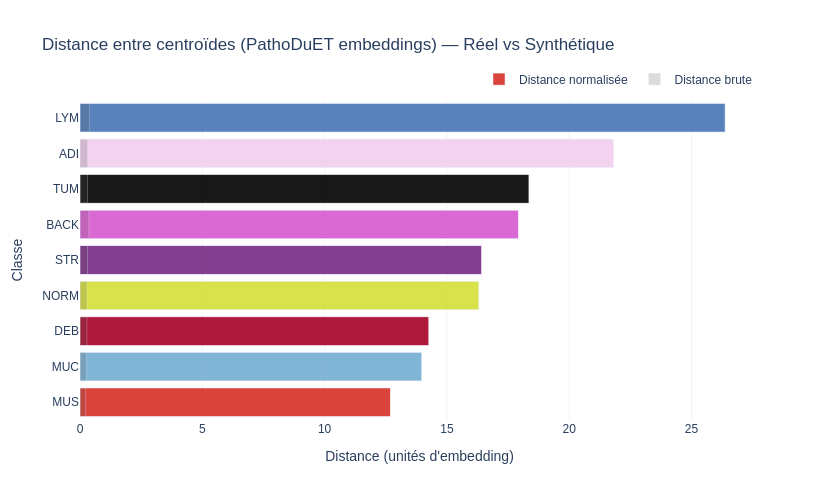

In [9]:
# =========================================================
# 09) Visualisation Plotly — Distance des centroïdes (brute & normalisée)
# =========================================================
import plotly.graph_objects as go

# Tri pour ordre visuel cohérent
df_sorted = df_dists.sort_values("Distance_normalisée", ascending=True)

# Couleurs cohérentes avec class_mappings
bar_colors = [class_colors.get(cls, "#777777") for cls in df_sorted["Classe"]]

# --- Figure avec deux barres par classe ---
fig = go.Figure()

# Distance normalisée
fig.add_trace(go.Bar(
    y=df_sorted["Classe"],
    x=df_sorted["Distance_normalisée"],
    orientation="h",
    name="Distance normalisée",
    marker_color=bar_colors,
    opacity=0.9
))

# Distance brute (traitée différemment pour comparaison)
fig.add_trace(go.Bar(
    y=df_sorted["Classe"],
    x=df_sorted["Distance_brute"],
    orientation="h",
    name="Distance brute",
    marker_color="rgba(80,80,80,0.4)",
    opacity=0.5
))

# --- Mise en forme ---
fig.update_layout(
    title="Distance entre centroïdes (PathoDuET embeddings) — Réel vs Synthétique",
    barmode="overlay",  # superpose brute / normalisée
    xaxis_title="Distance (unités d'embedding)",
    yaxis_title="Classe",
    width=950,
    height=500,
    plot_bgcolor="white",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

# Grille légère pour lecture
fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor="rgba(0,0,0,0.1)")
fig.update_yaxes(showgrid=False)

fig.show()
